In [1]:
!pip install beautifulsoup4
!pip install lxml

In [2]:
from bs4 import BeautifulSoup
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Dense, InputLayer, GRU, LSTM, Embedding, Bidirectional, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import csv
import os, shutil
import matplotlib.pyplot as plt
from google.colab import drive
import re

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data

In [4]:
pages_folder = '/content/drive/MyDrive/Colab Notebooks/pages'
sentences = []
with open('/content/drive/MyDrive/Colab Notebooks/enwik8.xml', 'r') as file:
    text = file.read()
    text = text.strip()
    # lines = text.split('\n')
    # for line in lines:
    #     if len(line) > 0:
    #         sentences.append(line)

bg_data = BeautifulSoup(text, 'xml')
# print(len(sentences))

In [5]:
pages = bg_data.find_all('page')
page_texts = []
for page in pages:
  page_text = page.find('text').text
  if page_text.startswith('#REDIRECT'):
    continue
  page_texts.append(page_text)

len(page_texts), len(pages)

(8967, 12347)

In [6]:
page_texts = page_texts[:100]

In [7]:
lines = page_texts[0].split('\n')
text_lines = []
for line in lines:
  if len(line.strip()) == 0:
    continue
  text_lines.append(line)

len(text_lines), len(lines)

(238, 350)

In [8]:
text_lines[1]

'\'\'\'Anarchism\'\'\' originated as a term of abuse first used against early [[working class]] [[radical]]s including the [[Diggers]] of the [[English Revolution]] and the [[sans-culotte|\'\'sans-culottes\'\']] of the [[French Revolution]].[http://uk.encarta.msn.com/encyclopedia_761568770/Anarchism.html] Whilst the term is still used in a pejorative way to describe \'\'"any act that used violent means to destroy the organization of society"\'\'<ref>[http://www.cas.sc.edu/socy/faculty/deflem/zhistorintpolency.html History of International Police Cooperation], from the final protocols of the "International Conference of Rome for the Social Defense Against Anarchists", 1898</ref>, it has also been taken up as a positive label by self-defined anarchists.'

In [9]:
sentences = []
for i in range(len(page_texts)):
  page_lines = page_texts[i].strip().split('\n')
  for line in page_lines:
    if len(line.strip()) == 0:
      continue
    sentences.append(line)

len(sentences)

13731

# Tokenizing the data

In [10]:
tokenizer = Tokenizer(oov_token='OOV')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
len(word_index)

26670

In [11]:
# Filtering the text to create n-ragged sequences
# print(len(sentences[0]))

def remove_extra_characters(text):
    filtered_text = []
    for item in text:
        new_text = re.sub('<ref>.*</ref>', '', item)
        new_text = re.sub('&#[0-9]*?;', '', new_text)
        new_text = re.sub('http://.*? ', '', new_text)
        new_text = new_text.replace('=', '')
        new_text = new_text.replace('_', ' ')
        new_text = new_text.replace('.', ' ')
        new_text = new_text.replace(',', '')
        new_text = new_text.replace(':', '')
        new_text = new_text.replace('!', '')
        new_text = new_text.replace('|', ' ')
        new_text = new_text.replace('$', '')
        new_text = new_text.replace('-', '')
        new_text = new_text.replace('(', '')
        new_text = new_text.replace(')', '')
        new_text = new_text.replace('  ', ' ')
        new_text = new_text.replace('“', '')
        new_text = new_text.replace('”', '')
        new_text = new_text.replace('\'', '')
        new_text = new_text.replace(']', '')
        new_text = new_text.replace('[', '')
        new_text = new_text.replace('"', '')
        new_text = new_text.strip()
        filtered_text.append(new_text)
    return filtered_text

# filtered_sentences = remove_extra_characters(sentences)

# print(len(filtered_sentences[0]))

In [12]:
def generate_pages(folder, pages):
  folder_path = os.path.join(pages_folder, folder)
  if os.path.isdir(folder_path):
    shutil.rmtree(folder_path)

  if not os.path.isdir(folder_path):
      os.makedirs(folder_path)

  for i in tqdm(range(len(pages))):
    page_text = pages[i]
    page_lines = []
    lines = page_text.split('\n')
    for line in lines:
      if len(line.strip()) < 3:
        continue
      page_lines.append(line)
    cleared_sentences = remove_extra_characters(page_lines)
    file_name = f'page_{i}.txt'
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'w') as file:
      file.writelines(cleared_sentences)

In [13]:
# Storing the data for individual page in to a separate file to laod separately
train_test_split = 0.9
train_page_num = int(len(page_texts) * train_test_split)
train_pages = page_texts[:train_page_num]
test_pages = page_texts[train_page_num:]

generate_pages('train', train_pages)
generate_pages('test', test_pages)

100%|██████████| 10/10 [00:00<00:00, 128.47it/s]


# Preparing the Dataset

In [14]:
# Creating the data generator
class TextDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, pages_dir, tokenizer, max_sentence_len, batch_size):
    self.pages_dir = pages_dir
    self.pages = os.listdir(pages_dir)
    self.tokenizer = tokenizer
    self.max_len = max_sentence_len

  def __len__(self):
    return len(self.pages)

  def __getitem__(self, index):
    page = self.pages[index]
    page_path = os.path.join(self.pages_dir, page)
    text_lines = []
    with open(page_path, 'r') as file:
      text_lines = file.readlines()

    text_lines = text_lines[:batch_size]
    # Tokenizing the sequence
    sequences = self.tokenizer.texts_to_sequences(text_lines)
    n_ragged_sequences = []
    # Creating n-ragged sequences
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            new_sequence = sequence[0:i+2]
            n_ragged_sequences.append(new_sequence)
    padded_sequences = pad_sequences(n_ragged_sequences, maxlen=self.max_len, padding= 'pre')
    X = padded_sequences[:, :-1]
    y = padded_sequences[:, -1]
    return X, y

# Defining the Model

In [15]:
max_length = 120
train_folder = os.path.join(pages_folder, 'train')
test_folder = os.path.join(pages_folder, 'test')
train_gen = TextDataGenerator(train_folder, tokenizer, max_length, 64)
test_gen = TextDataGenerator(test_folder, tokenizer, max_length, 32)

In [16]:
num_labels = len(tokenizer.word_index) + 1
epochs = 100
batch_size = 1024
num_labels

26671

In [17]:
model = Sequential([
    Embedding(num_labels, 64, input_length=max_length - 1),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(units= num_labels, activation= 'softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 119, 64)           1706944   
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 26671)             3440559   
                                                                 
Total params: 5213551 (19.89 MB)
Trainable params: 5213551 (19.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
checkpoint = ModelCheckpoint(filepath= 'predictor.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch', verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
history = model.fit(train_gen,epochs=epochs, batch_size=256, callbacks=[checkpoint, earlyStopping])

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 8.5030 - accuracy: 0.0514

90/90 [==============================] - 36s 326ms/step - loss: 8.5030 - accuracy: 0.0514
Epoch 2/100
89/90 [============================>.] - ETA: 0s - loss: 7.4930 - accuracy: 0.0566

90/90 [==============================] - 15s 166ms/step - loss: 7.4922 - accuracy: 0.0566
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 7.4297 - accuracy: 0.0565

90/90 [==============================] - 14s 155ms/step - loss: 7.4297 - accuracy: 0.0565
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 7.3875 - accuracy: 0.0589

90/90 [==============================] - 14s 161ms/step - loss: 7.3875 - accuracy: 0.0589
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 7.3467 - accuracy: 0.0671

90/90 [==============================] - 14s 152ms/step - loss: 7.3467 - accuracy: 0.0671
Epoch 6/100
89/90 [============================>.] - ETA: 0s - loss: 7.3503 - accuracy: 0.0736

90/90 [==============================] - 15s 160ms/step - loss: 7.3498 - accuracy: 0.0736
Epoch 7/100
89/90 [============================>.] - ETA: 0s - loss: 7.2870 - accuracy: 0.0819

90/90 [==============================] - 14s 150ms/step - loss: 7.2866 - accuracy: 0.0819
Epoch 8/100
90/90 [==============================] - ETA: 0s - loss: 7.2702 - accuracy: 0.0854

90/90 [==============================] - 14s 159ms/step - loss: 7.2702 - accuracy: 0.0854
Epoch 9/100
90/90 [==============================] - ETA: 0s - loss: 7.2549 - accuracy: 0.0885

90/90 [==============================] - 15s 165ms/step - loss: 7.2549 - accuracy: 0.0885
Epoch 10/100
90/90 [==============================] - ETA: 0s - loss: 7.2054 - accuracy: 0.0921

90/90 [==============================] - 14s 154ms/step - loss: 7.2054 - accuracy: 0.0921
Epoch 11/100
90/90 [==============================] - ETA: 0s - loss: 7.1877 - accuracy: 0.0951

90/90 [==============================] - 15s 163ms/step - loss: 7.1877 - accuracy: 0.0951
Epoch 12/100
90/90 [==============================] - ETA: 0s - loss: 7.1318 - accuracy: 0.0977

90/90 [==============================] - 14s 159ms/step - loss: 7.1318 - accuracy: 0.0977
Epoch 13/100
90/90 [==============================] - ETA: 0s - loss: 7.0888 - accuracy: 0.1005

90/90 [==============================] - 15s 163ms/step - loss: 7.0888 - accuracy: 0.1005
Epoch 14/100
90/90 [==============================] - ETA: 0s - loss: 7.0514 - accuracy: 0.1049

90/90 [==============================] - 14s 156ms/step - loss: 7.0514 - accuracy: 0.1049
Epoch 15/100
89/90 [============================>.] - ETA: 0s - loss: 7.0152 - accuracy: 0.1079

90/90 [==============================] - 14s 159ms/step - loss: 7.0151 - accuracy: 0.1079
Epoch 16/100
90/90 [==============================] - ETA: 0s - loss: 6.9690 - accuracy: 0.1107

90/90 [==============================] - 15s 171ms/step - loss: 6.9690 - accuracy: 0.1107
Epoch 17/100
90/90 [==============================] - ETA: 0s - loss: 6.9327 - accuracy: 0.1130

90/90 [==============================] - 15s 158ms/step - loss: 6.9327 - accuracy: 0.1130
Epoch 18/100
90/90 [==============================] - ETA: 0s - loss: 6.8904 - accuracy: 0.1150

90/90 [==============================] - 15s 163ms/step - loss: 6.8904 - accuracy: 0.1150
Epoch 19/100
89/90 [============================>.] - ETA: 0s - loss: 6.8442 - accuracy: 0.1172

90/90 [==============================] - 14s 158ms/step - loss: 6.8428 - accuracy: 0.1173
Epoch 20/100
89/90 [============================>.] - ETA: 0s - loss: 6.7966 - accuracy: 0.1202

90/90 [==============================] - 14s 155ms/step - loss: 6.7951 - accuracy: 0.1202
Epoch 21/100
90/90 [==============================] - ETA: 0s - loss: 6.7619 - accuracy: 0.1217

90/90 [==============================] - 15s 168ms/step - loss: 6.7619 - accuracy: 0.1217
Epoch 22/100
90/90 [==============================] - ETA: 0s - loss: 6.7329 - accuracy: 0.1224

90/90 [==============================] - 14s 161ms/step - loss: 6.7329 - accuracy: 0.1224
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 6.6820 - accuracy: 0.1240

90/90 [==============================] - 14s 159ms/step - loss: 6.6820 - accuracy: 0.1240
Epoch 24/100
89/90 [============================>.] - ETA: 0s - loss: 6.6351 - accuracy: 0.1261

90/90 [==============================] - 14s 156ms/step - loss: 6.6343 - accuracy: 0.1260
Epoch 25/100
90/90 [==============================] - ETA: 0s - loss: 6.5897 - accuracy: 0.1280

90/90 [==============================] - 14s 154ms/step - loss: 6.5897 - accuracy: 0.1280
Epoch 26/100
90/90 [==============================] - ETA: 0s - loss: 6.5455 - accuracy: 0.1294

90/90 [==============================] - 14s 156ms/step - loss: 6.5455 - accuracy: 0.1294
Epoch 27/100
90/90 [==============================] - ETA: 0s - loss: 6.5115 - accuracy: 0.1314

90/90 [==============================] - 14s 160ms/step - loss: 6.5115 - accuracy: 0.1314
Epoch 28/100
90/90 [==============================] - ETA: 0s - loss: 6.4782 - accuracy: 0.1331

90/90 [==============================] - 15s 154ms/step - loss: 6.4782 - accuracy: 0.1331
Epoch 29/100
90/90 [==============================] - ETA: 0s - loss: 6.4475 - accuracy: 0.1349

90/90 [==============================] - 15s 167ms/step - loss: 6.4475 - accuracy: 0.1349
Epoch 30/100
90/90 [==============================] - ETA: 0s - loss: 6.3989 - accuracy: 0.1371

90/90 [==============================] - 14s 157ms/step - loss: 6.3989 - accuracy: 0.1371
Epoch 31/100
90/90 [==============================] - ETA: 0s - loss: 6.3619 - accuracy: 0.1389

90/90 [==============================] - 15s 164ms/step - loss: 6.3619 - accuracy: 0.1389
Epoch 32/100
90/90 [==============================] - ETA: 0s - loss: 6.3093 - accuracy: 0.1407

90/90 [==============================] - 14s 162ms/step - loss: 6.3093 - accuracy: 0.1407
Epoch 33/100
90/90 [==============================] - ETA: 0s - loss: 6.2781 - accuracy: 0.1421

90/90 [==============================] - 14s 159ms/step - loss: 6.2781 - accuracy: 0.1421
Epoch 34/100
90/90 [==============================] - ETA: 0s - loss: 6.2483 - accuracy: 0.1436

90/90 [==============================] - 14s 159ms/step - loss: 6.2483 - accuracy: 0.1436
Epoch 35/100
90/90 [==============================] - ETA: 0s - loss: 6.1957 - accuracy: 0.1449

90/90 [==============================] - 15s 165ms/step - loss: 6.1957 - accuracy: 0.1449
Epoch 36/100
90/90 [==============================] - ETA: 0s - loss: 6.1629 - accuracy: 0.1466

90/90 [==============================] - 14s 154ms/step - loss: 6.1629 - accuracy: 0.1466
Epoch 37/100
90/90 [==============================] - ETA: 0s - loss: 6.1452 - accuracy: 0.1471

90/90 [==============================] - 15s 150ms/step - loss: 6.1452 - accuracy: 0.1471
Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 6.0946 - accuracy: 0.1480

90/90 [==============================] - 15s 166ms/step - loss: 6.0946 - accuracy: 0.1480
Epoch 39/100
90/90 [==============================] - ETA: 0s - loss: 6.0525 - accuracy: 0.1495

90/90 [==============================] - 15s 163ms/step - loss: 6.0525 - accuracy: 0.1495
Epoch 40/100
89/90 [============================>.] - ETA: 0s - loss: 6.0208 - accuracy: 0.1519

90/90 [==============================] - 15s 167ms/step - loss: 6.0203 - accuracy: 0.1519
Epoch 41/100
90/90 [==============================] - ETA: 0s - loss: 5.9774 - accuracy: 0.1534

90/90 [==============================] - 15s 163ms/step - loss: 5.9774 - accuracy: 0.1534
Epoch 42/100
90/90 [==============================] - ETA: 0s - loss: 5.9437 - accuracy: 0.1542

90/90 [==============================] - 15s 171ms/step - loss: 5.9437 - accuracy: 0.1542
Epoch 43/100
90/90 [==============================] - ETA: 0s - loss: 5.9119 - accuracy: 0.1558

90/90 [==============================] - 14s 160ms/step - loss: 5.9119 - accuracy: 0.1558
Epoch 44/100
89/90 [============================>.] - ETA: 0s - loss: 5.8814 - accuracy: 0.1577

90/90 [==============================] - 14s 156ms/step - loss: 5.8813 - accuracy: 0.1578
Epoch 45/100
90/90 [==============================] - ETA: 0s - loss: 5.8448 - accuracy: 0.1599

90/90 [==============================] - 15s 162ms/step - loss: 5.8448 - accuracy: 0.1599
Epoch 46/100
90/90 [==============================] - ETA: 0s - loss: 5.8112 - accuracy: 0.1619

90/90 [==============================] - 15s 160ms/step - loss: 5.8112 - accuracy: 0.1619
Epoch 47/100
89/90 [============================>.] - ETA: 0s - loss: 5.7729 - accuracy: 0.1635

90/90 [==============================] - 15s 155ms/step - loss: 5.7694 - accuracy: 0.1638
Epoch 48/100
90/90 [==============================] - ETA: 0s - loss: 5.7383 - accuracy: 0.1646

90/90 [==============================] - 15s 164ms/step - loss: 5.7383 - accuracy: 0.1646
Epoch 49/100
90/90 [==============================] - ETA: 0s - loss: 5.7001 - accuracy: 0.1677

90/90 [==============================] - 14s 161ms/step - loss: 5.7001 - accuracy: 0.1677
Epoch 50/100
88/90 [============================>.] - ETA: 0s - loss: 5.6708 - accuracy: 0.1704

90/90 [==============================] - 14s 156ms/step - loss: 5.6698 - accuracy: 0.1705
Epoch 51/100
88/90 [============================>.] - ETA: 0s - loss: 5.6339 - accuracy: 0.1729

90/90 [==============================] - 15s 165ms/step - loss: 5.6328 - accuracy: 0.1730
Epoch 52/100
90/90 [==============================] - ETA: 0s - loss: 5.6101 - accuracy: 0.1733

90/90 [==============================] - 15s 163ms/step - loss: 5.6101 - accuracy: 0.1733
Epoch 53/100
90/90 [==============================] - ETA: 0s - loss: 5.5780 - accuracy: 0.1764

90/90 [==============================] - 15s 160ms/step - loss: 5.5780 - accuracy: 0.1764
Epoch 54/100
90/90 [==============================] - ETA: 0s - loss: 5.5409 - accuracy: 0.1803

90/90 [==============================] - 15s 164ms/step - loss: 5.5409 - accuracy: 0.1803
Epoch 55/100
90/90 [==============================] - ETA: 0s - loss: 5.5036 - accuracy: 0.1823

90/90 [==============================] - 14s 156ms/step - loss: 5.5036 - accuracy: 0.1823
Epoch 56/100
89/90 [============================>.] - ETA: 0s - loss: 5.4650 - accuracy: 0.1854

90/90 [==============================] - 14s 157ms/step - loss: 5.4648 - accuracy: 0.1854
Epoch 57/100
90/90 [==============================] - ETA: 0s - loss: 5.4383 - accuracy: 0.1874

90/90 [==============================] - 14s 162ms/step - loss: 5.4383 - accuracy: 0.1874
Epoch 58/100
90/90 [==============================] - ETA: 0s - loss: 5.4152 - accuracy: 0.1900

90/90 [==============================] - 15s 163ms/step - loss: 5.4152 - accuracy: 0.1900
Epoch 59/100
90/90 [==============================] - ETA: 0s - loss: 5.3808 - accuracy: 0.1928

90/90 [==============================] - 15s 164ms/step - loss: 5.3808 - accuracy: 0.1928
Epoch 60/100
90/90 [==============================] - ETA: 0s - loss: 5.3562 - accuracy: 0.1948

90/90 [==============================] - 14s 160ms/step - loss: 5.3562 - accuracy: 0.1948
Epoch 61/100
90/90 [==============================] - ETA: 0s - loss: 5.3243 - accuracy: 0.1982

90/90 [==============================] - 15s 164ms/step - loss: 5.3243 - accuracy: 0.1982
Epoch 62/100
89/90 [============================>.] - ETA: 0s - loss: 5.2940 - accuracy: 0.2006

90/90 [==============================] - 15s 158ms/step - loss: 5.2893 - accuracy: 0.2010
Epoch 63/100
90/90 [==============================] - ETA: 0s - loss: 5.2638 - accuracy: 0.2032

90/90 [==============================] - 14s 161ms/step - loss: 5.2638 - accuracy: 0.2032
Epoch 64/100
89/90 [============================>.] - ETA: 0s - loss: 5.2328 - accuracy: 0.2068

90/90 [==============================] - 15s 167ms/step - loss: 5.2291 - accuracy: 0.2070
Epoch 65/100
90/90 [==============================] - ETA: 0s - loss: 5.2045 - accuracy: 0.2092

90/90 [==============================] - 14s 156ms/step - loss: 5.2045 - accuracy: 0.2092
Epoch 66/100
89/90 [============================>.] - ETA: 0s - loss: 5.1845 - accuracy: 0.2118

90/90 [==============================] - 15s 164ms/step - loss: 5.1808 - accuracy: 0.2122
Epoch 67/100
90/90 [==============================] - ETA: 0s - loss: 5.1450 - accuracy: 0.2152

90/90 [==============================] - 14s 158ms/step - loss: 5.1450 - accuracy: 0.2152
Epoch 68/100
90/90 [==============================] - ETA: 0s - loss: 5.1215 - accuracy: 0.2170

90/90 [==============================] - 14s 160ms/step - loss: 5.1215 - accuracy: 0.2170
Epoch 69/100
89/90 [============================>.] - ETA: 0s - loss: 5.0935 - accuracy: 0.2200

90/90 [==============================] - 14s 158ms/step - loss: 5.0895 - accuracy: 0.2202
Epoch 70/100
90/90 [==============================] - ETA: 0s - loss: 5.0681 - accuracy: 0.2229

90/90 [==============================] - 15s 156ms/step - loss: 5.0681 - accuracy: 0.2229
Epoch 71/100
90/90 [==============================] - ETA: 0s - loss: 5.0442 - accuracy: 0.2257

90/90 [==============================] - 15s 162ms/step - loss: 5.0442 - accuracy: 0.2257
Epoch 72/100
90/90 [==============================] - ETA: 0s - loss: 5.0154 - accuracy: 0.2282

90/90 [==============================] - 14s 159ms/step - loss: 5.0154 - accuracy: 0.2282
Epoch 73/100
89/90 [============================>.] - ETA: 0s - loss: 4.9889 - accuracy: 0.2313

90/90 [==============================] - 14s 157ms/step - loss: 4.9882 - accuracy: 0.2315
Epoch 74/100
90/90 [==============================] - ETA: 0s - loss: 4.9566 - accuracy: 0.2344

90/90 [==============================] - 15s 164ms/step - loss: 4.9566 - accuracy: 0.2344
Epoch 75/100
90/90 [==============================] - ETA: 0s - loss: 4.9344 - accuracy: 0.2361

90/90 [==============================] - 14s 155ms/step - loss: 4.9344 - accuracy: 0.2361
Epoch 76/100
90/90 [==============================] - ETA: 0s - loss: 4.8985 - accuracy: 0.2406

90/90 [==============================] - 14s 161ms/step - loss: 4.8985 - accuracy: 0.2406
Epoch 77/100
90/90 [==============================] - ETA: 0s - loss: 4.8837 - accuracy: 0.2425

90/90 [==============================] - 15s 158ms/step - loss: 4.8837 - accuracy: 0.2425
Epoch 78/100
90/90 [==============================] - ETA: 0s - loss: 4.8508 - accuracy: 0.2458

90/90 [==============================] - 15s 154ms/step - loss: 4.8508 - accuracy: 0.2458
Epoch 79/100
90/90 [==============================] - ETA: 0s - loss: 4.8298 - accuracy: 0.2480

90/90 [==============================] - 14s 162ms/step - loss: 4.8298 - accuracy: 0.2480
Epoch 80/100
90/90 [==============================] - ETA: 0s - loss: 4.8068 - accuracy: 0.2501

90/90 [==============================] - 15s 166ms/step - loss: 4.8068 - accuracy: 0.2501
Epoch 81/100
90/90 [==============================] - ETA: 0s - loss: 4.7769 - accuracy: 0.2543

90/90 [==============================] - 15s 169ms/step - loss: 4.7769 - accuracy: 0.2543
Epoch 82/100
89/90 [============================>.] - ETA: 0s - loss: 4.7599 - accuracy: 0.2554

90/90 [==============================] - 15s 162ms/step - loss: 4.7597 - accuracy: 0.2554
Epoch 83/100
89/90 [============================>.] - ETA: 0s - loss: 4.7363 - accuracy: 0.2580

90/90 [==============================] - 15s 166ms/step - loss: 4.7353 - accuracy: 0.2582
Epoch 84/100
90/90 [==============================] - ETA: 0s - loss: 4.7153 - accuracy: 0.2609

90/90 [==============================] - 14s 156ms/step - loss: 4.7153 - accuracy: 0.2609
Epoch 85/100
90/90 [==============================] - ETA: 0s - loss: 4.6858 - accuracy: 0.2631

90/90 [==============================] - 15s 158ms/step - loss: 4.6858 - accuracy: 0.2631
Epoch 86/100
90/90 [==============================] - ETA: 0s - loss: 4.6630 - accuracy: 0.2653

90/90 [==============================] - 15s 162ms/step - loss: 4.6630 - accuracy: 0.2653
Epoch 87/100
89/90 [============================>.] - ETA: 0s - loss: 4.6417 - accuracy: 0.2686

90/90 [==============================] - 14s 159ms/step - loss: 4.6415 - accuracy: 0.2686
Epoch 88/100
89/90 [============================>.] - ETA: 0s - loss: 4.6288 - accuracy: 0.2702

90/90 [==============================] - 15s 158ms/step - loss: 4.6287 - accuracy: 0.2703
Epoch 89/100
90/90 [==============================] - ETA: 0s - loss: 4.6004 - accuracy: 0.2726

90/90 [==============================] - 15s 160ms/step - loss: 4.6004 - accuracy: 0.2726
Epoch 90/100
90/90 [==============================] - ETA: 0s - loss: 4.5844 - accuracy: 0.2743

90/90 [==============================] - 14s 151ms/step - loss: 4.5844 - accuracy: 0.2743
Epoch 91/100
90/90 [==============================] - ETA: 0s - loss: 4.5540 - accuracy: 0.2780

90/90 [==============================] - 14s 158ms/step - loss: 4.5540 - accuracy: 0.2780
Epoch 92/100
89/90 [============================>.] - ETA: 0s - loss: 4.5442 - accuracy: 0.2800

90/90 [==============================] - 14s 161ms/step - loss: 4.5441 - accuracy: 0.2800
Epoch 93/100
88/90 [============================>.] - ETA: 0s - loss: 4.5136 - accuracy: 0.2824

90/90 [==============================] - 14s 155ms/step - loss: 4.5128 - accuracy: 0.2825
Epoch 94/100
90/90 [==============================] - ETA: 0s - loss: 4.5022 - accuracy: 0.2835

90/90 [==============================] - 15s 164ms/step - loss: 4.5022 - accuracy: 0.2835
Epoch 95/100
90/90 [==============================] - ETA: 0s - loss: 4.4803 - accuracy: 0.2868

90/90 [==============================] - 14s 153ms/step - loss: 4.4803 - accuracy: 0.2868
Epoch 96/100
90/90 [==============================] - ETA: 0s - loss: 4.4566 - accuracy: 0.2898

90/90 [==============================] - 14s 158ms/step - loss: 4.4566 - accuracy: 0.2898
Epoch 97/100
90/90 [==============================] - ETA: 0s - loss: 4.4301 - accuracy: 0.2905

90/90 [==============================] - 15s 162ms/step - loss: 4.4301 - accuracy: 0.2905
Epoch 98/100
89/90 [============================>.] - ETA: 0s - loss: 4.4210 - accuracy: 0.2930

90/90 [==============================] - 15s 164ms/step - loss: 4.4143 - accuracy: 0.2938
Epoch 99/100
90/90 [==============================] - ETA: 0s - loss: 4.3939 - accuracy: 0.2959

90/90 [==============================] - 14s 162ms/step - loss: 4.3939 - accuracy: 0.2959
Epoch 100/100
90/90 [==============================] - ETA: 0s - loss: 4.3777 - accuracy: 0.2975

90/90 [==============================] - 14s 157ms/step - loss: 4.3777 - accuracy: 0.2975


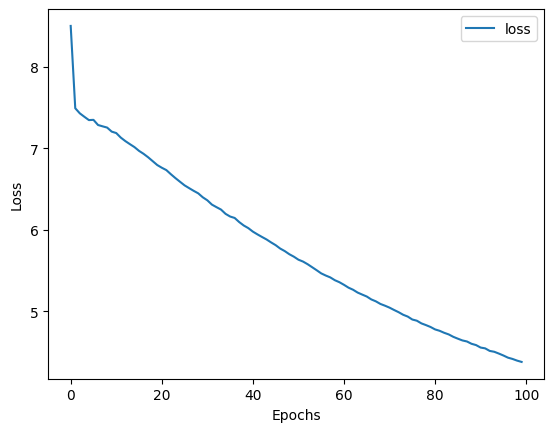

In [21]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

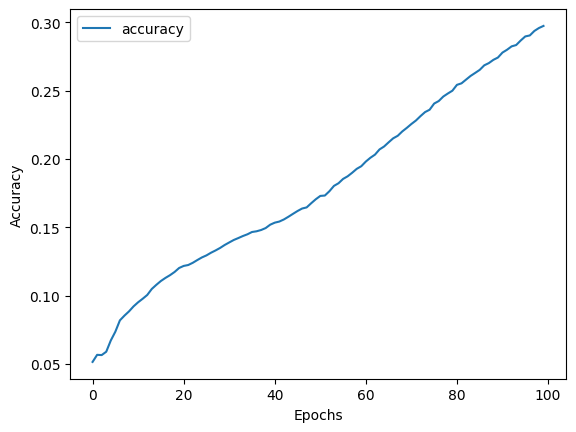

In [22]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])